In [ ]:
# Import statements

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split


## We'll define functions to extract HOG features

In [ ]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32), hist_bins=32):
    # Create a list to append feature vectors to

    features = []
    
    print ("total images to train = ", len(imgs))

    # Iterate through the list of images
    for file in imgs:
        
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)     
            
        # Add spatial features & hist features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        file_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append all the different features to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Next, we'll read in both the car images and non-car images to train the classifier

In [ ]:
# Read in car and non-car images
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

## Train the SVC - commented after training

In [12]:


'''
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)
hist_bins = 32

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block', spatial_size, 'spatial_size and',
     hist_bins, 'hist_bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Save our training data weights
import pickle

pickle.dump( svc, open( "svc.p", "wb" ) )
pickle.dump(X_scaler, open("X_scaler.p", "wb"))
print ("Saved pickle")'''


'\n### TODO: Tweak these parameters and see how the results change.\ncolorspace = \'YCrCb\' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb\norient = 9\npix_per_cell = 8\ncell_per_block = 2\nhog_channel = \'ALL\' # Can be 0, 1, 2, or "ALL"\nspatial_size = (32,32)\nhist_bins = 32\n\nt=time.time()\ncar_features = extract_features(cars, cspace=colorspace, orient=orient, \n                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \n                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)\nnotcar_features = extract_features(notcars, cspace=colorspace, orient=orient, \n                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \n                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)\n\nt2 = time.time()\nprint(round(t2-t, 2), \'Seconds to extract HOG features...\')\n# Create an array stack of feature vectors\nX = np.vstack((car_features, notcar_features)).astype(np.float64)

## Check the accuracy of the SVC - commented after training

In [13]:

'''print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
'''

"print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))\n# Check the prediction time for a single sample\nt=time.time()\nn_predict = 10\nprint('My SVC predicts: ', svc.predict(X_test[0:n_predict]))\nprint('For these',n_predict, 'labels: ', y_test[0:n_predict])\nt2 = time.time()\nprint(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')\n"

## Hog sub sampling window search

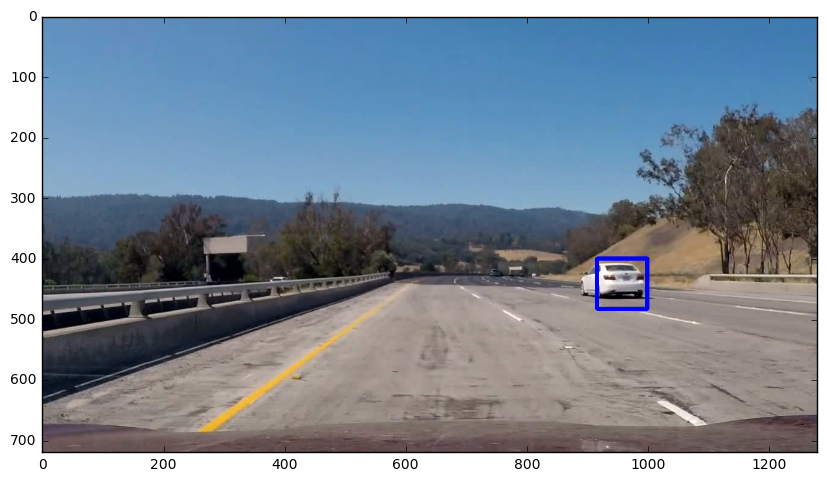

In [43]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features






# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_old(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # Addition for heatmap implementation
    heatmap = np.zeros_like(img[:,:,0])
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 3  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(hog_features).reshape(1, -1) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                # Heatmap implemenation
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    scale_choose = [1.3, 1.5, 1.8]
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    for scale in scale_choose:
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        if scale == 1.8:
            cells_per_step = 3
        else:
            cells_per_step = 2
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap

'''# import our saved svm object
#Commented out - uncomment for debug purposes
svc =  pickle.load( open( "svc.p", "rb" ) )
X_scaler = pickle.load(open( "X_scaler.p", "rb" ))
spatial_size =(32,32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
ystart = 400
ystop = 656
scale = 1.8

img = mpimg.imread('test_frame.jpg')
    
out_img, heatmap = find_cars(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.show()'''

## Heat Map to consolidate multiple detections and remove false positives

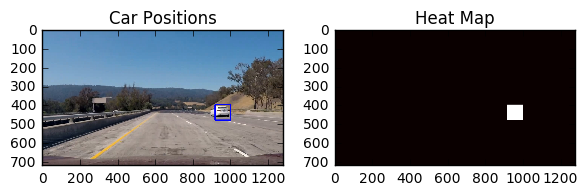

In [44]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    all_box = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        all_box.append(bbox)
    # Return the image and the bound boxes
    return img, all_box

'''#Debug - not used for production run
# import our saved svm object
svc =  pickle.load( open( "svc.p", "rb" ) )
X_scaler = pickle.load(open( "X_scaler.p", "rb" ))
spatial_size =(32,32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
ystart = 400
ystop = 656

# Read in image similar to one shown above 
img = mpimg.imread('test_frame.jpg')
out_img, heatmap = find_cars(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Apply threshold to help remove false positives
heat = apply_threshold(heatmap,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, bbox = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.show()
'''

## Pipeline defintion - put together all that we learnt so far

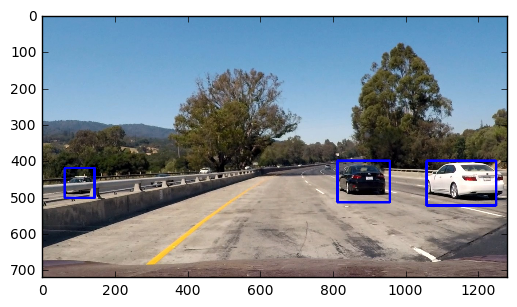

In [47]:
class Car():
    def __init__(self):
        #Previous frames heatmaps
        self.heatmap = np.array([None]*10)
        #first frame 
        self.first_frame = True
        self.smoothened = 10
global vehicle_detected
vehicle_detected = Car()

# One time run required to initialize SVM
# import our saved svm object
svc =  pickle.load( open( "svc.p", "rb" ) )
X_scaler = pickle.load(open( "X_scaler.p", "rb" ))


def process_image(image):
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32,32)
    hist_bins = 32
    ystart = 400
    ystop = 656

    out_img, heatmap = find_cars(image, ystart, ystop, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    if vehicle_detected.first_frame == True:
        applied_threshold = apply_threshold(np.copy(heatmap), 1)
        #make the history same as the first frame
        vehicle_detected.heatmap = np.array([applied_threshold] * vehicle_detected.smoothened)
        vehicle_detected.first_frame = False
        labels = label(applied_threshold)
    else:    
        #look into previous frames   
        vehicle_detected.heatmap[0:-1] = vehicle_detected.heatmap[1:]
        vehicle_detected.heatmap[-1] = heatmap
        new_previous_frame_threshold = vehicle_detected.heatmap.sum(axis=0)

        applied_threshold = apply_threshold(np.copy(new_previous_frame_threshold), vehicle_detected.smoothened*2+5)
        labels = label(applied_threshold)
        
    draw_labeled, bbox = draw_labeled_bboxes(np.copy(image), labels)
    #bias the position of the detected region by adding +1 to it
    vehicle_detected.heatmap[-1] = add_heat(vehicle_detected.heatmap[-1], bbox)

    return draw_labeled

'''# Debug test on few images the pipeline
# Read in image similar to one shown above 
img = mpimg.imread('test_images/test1.jpg')

final_output = process_image(img)

plt.imshow(final_output)
plt.show()
'''

## Video output

In [49]:
import imageio

imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip

'''
# WOrkaround to avoid AWS timeout issues
for i in range(20,50,5):
    
    white_output = 'project_video_output_' + str(i) + '.mp4'
    if i == 0:
        print("Processing with starttime: " + str(i) + " and endtime: " + str(i+5))
        print("Output file: " + white_output)
        clip1 = VideoFileClip("project_video.mp4").subclip(i, i+5)
    elif i == 45:
        print("Processing with starttime: " + str(i) + " and endtime: " + str(50.4))
        clip1 = VideoFileClip("project_video.mp4").subclip(i, 50.4)
    else:
        
        print("Processing with starttime: " + str(i) + " and endtime: " + str(i+5))
        clip1 = VideoFileClip("project_video.mp4").subclip(i, i+5)
        
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)
'''

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid